# Heart Disease Prediction Using Ensemble Algorithms and Deep learning Models

### Task 1: Import Libraries

In [300]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import uniform as sp_uniform   
from scipy.stats import randint as sp_randint
import shap 
from sklearn.ensemble import RandomForestClassifier, StackingClassifier,BaggingClassifier ,GradientBoostingClassifier
import xgboost as xgb 
import catboost as cbt 
from sklearn import svm 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score
from scipy import stats
import statsmodels.api as sm

from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import f_regression, SelectKBest, f_classif

import warnings 
warnings.filterwarnings('ignore')

import os
import sys

### Task 2: Load the Heart Disease Dataset 

In [301]:
# Load the data
train = pd.read_csv('Train Dataset .csv')
test = pd.read_csv('Test Dataset.csv')
sample = pd.read_csv('Sample Submission.csv')

In [302]:
print(train.shape) 
print(test.shape)

(7303, 15)
(2697, 14)


### Data Assesment/Investigation

In [303]:
# Display the first five rows
train.head()

# Print the number of rows and columns, and column names
print(train.shape, train.columns)

# Count the number of missing values
print(train.isna().sum())


(7303, 15) Index(['Id', 'Age', 'Sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
Id          0
Age         0
Sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [304]:
test.head()

# Print the number of rows and columns, and column names
print(test.shape, test.columns)

# Count the number of missing values
print(test.isna().sum())

(2697, 14) Index(['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')
id          0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


<Axes: >

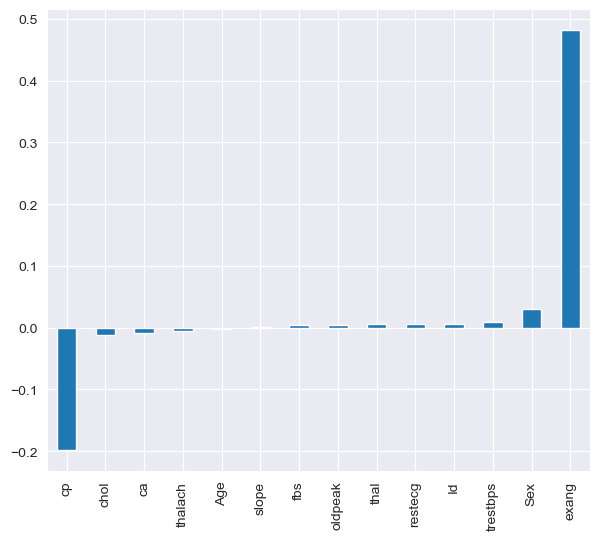

In [305]:
train.corr()['target'].drop("target").sort_values().plot(kind='bar', figsize=(7, 6))

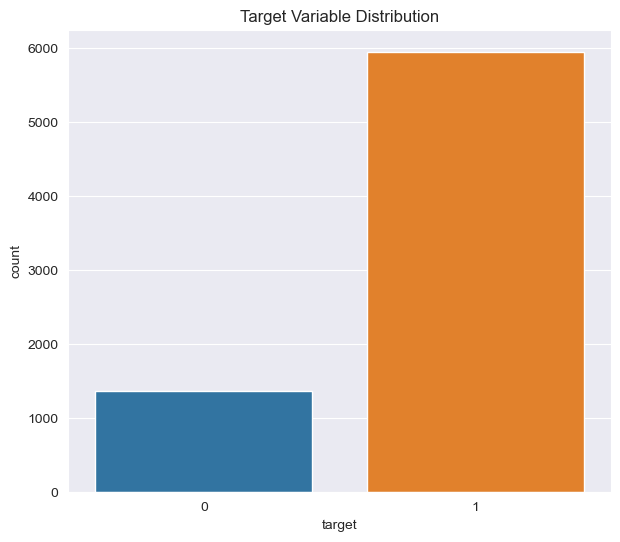

In [306]:
sns.set_style('darkgrid')
plt.figure(figsize=(7, 6))
sns.countplot(x = 'target', data = train)
plt.title('Target Variable Distribution')
plt.show()

In [307]:
target = train.target
train = train.drop("target", axis = 1)

In [308]:
train=train.rename({"Id":"id", 'Age':'age', 'Sex':'sex'},axis=1)

In [309]:
data=pd.concat([train,test])

In [310]:
data.isnull().sum()

id          0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64

In [311]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 2696
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        10000 non-null  int64  
 1   age       10000 non-null  int64  
 2   sex       10000 non-null  int64  
 3   cp        10000 non-null  int64  
 4   trestbps  10000 non-null  int64  
 5   chol      10000 non-null  int64  
 6   fbs       10000 non-null  int64  
 7   restecg   10000 non-null  int64  
 8   thalach   10000 non-null  int64  
 9   exang     10000 non-null  int64  
 10  oldpeak   10000 non-null  float64
 11  slope     10000 non-null  int64  
 12  ca        10000 non-null  int64  
 13  thal      10000 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 1.1 MB


In [312]:
# Define the ranking function
def rank_4_3_2_1(x):
    # Remove outliers using 3 standard deviations rule
    no_outliers = x[(x - x.mean()).abs() <= 3 * x.std()]
    q1 = no_outliers.quantile(0.25)
    q2 = no_outliers.quantile(0.5)
    q3 = no_outliers.quantile(0.75)
    ranks = pd.Series(index=x.index)
    ranks[x >= q3] = 2
    ranks[(x >= q2) & (x < q3)] = 3
    ranks[(x >= q1) & (x < q2)] = 4
    ranks[x < q1] = 1
    return ranks

# Get a list of the column names
columns = data.drop("id", axis=1).columns.tolist()

to_remove=[]
# Iterate over each column, rank the values, and add the result to a new column
for col in columns:
    ranks = rank_4_3_2_1(data[col])
    data[f"{col}_rank"] = ranks
    to_remove.append(f"{col}_rank")

# Calculate the sum of the ranks for each column
rank_sums = data.filter(regex="_rank$").sum(axis=1)

# Add the rank sums as a new row to the DataFrame
data["Rank_Sum"] = rank_sums
data = data.drop(to_remove, axis=1)

data


,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Rank_Sum
0,16167,33,0,1,158,205,1,0,154,0,1.5,1,4,1,32.0
1,11275,53,1,2,198,154,0,1,104,0,0.8,2,1,0,32.0
2,13251,37,1,2,101,202,1,0,155,0,2.1,1,3,1,32.0
3,19921,75,0,0,113,306,1,2,88,1,4.9,0,2,2,29.0
4,11293,35,1,2,139,419,1,1,166,1,0.9,2,4,0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,14964,34,0,3,136,291,0,1,163,0,2.6,2,2,3,37.0
2693,16774,72,0,1,104,166,1,2,95,1,0.3,0,2,2,27.0
2694,18884,31,1,0,153,457,1,1,170,1,3.8,0,3,1,30.0
2695,10000,71,0,0,111,242,1,0,147,1,5.3,0,1,2,34.0


#### Engineer new features 

In [313]:
data.columns

Index(['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'Rank_Sum'],
      dtype='object')

In [314]:
# Define age groups
bins = [0, 30, 40, 50, 60, float('inf')]
labels = ['<30', '30-40', '40-50', '50-60', '60+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels)

# Define blood pressure categories based on JNC 9 guidelines
bins_jnc9 = [0, 120, 129, 139, 140, float('inf')]
labels_jnc9 = ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertension Crisis']
data['bp_category'] = pd.cut(data['trestbps'], bins=bins_jnc9, labels=labels_jnc9)

# Create new features
data['cholesterol_age_ratio'] = data['chol'] / data['age']
data['heart_rate_reserve'] = (220 - data['age']) - data['thalach']
data['angina_chest_pain'] = data['exang'] * data['cp']
data['bp_to_hr_ratio'] = data['trestbps'] / data['thalach']
data['slope_age_ratio'] = data['slope'] / data['age']
data['vessels_age_ratio'] = data['ca'] / data['age']
data['high_fasting_blood_sugar'] = (data['fbs'] > 120).astype(int)

In [315]:
from sklearn.preprocessing import OrdinalEncoder

# Define columns to encode
columns_to_encode = ["age_group", "bp_category"]

# Initialize the encoder
encoder = OrdinalEncoder()

# Fit and transform the selected columns
data[columns_to_encode] = encoder.fit_transform(data[columns_to_encode])

data.dtypes


id                            int64
age                           int64
sex                           int64
cp                            int64
trestbps                      int64
chol                          int64
fbs                           int64
restecg                       int64
thalach                       int64
exang                         int64
oldpeak                     float64
slope                         int64
ca                            int64
thal                          int64
Rank_Sum                    float64
age_group                   float64
bp_category                 float64
cholesterol_age_ratio       float64
heart_rate_reserve            int64
angina_chest_pain             int64
bp_to_hr_ratio              float64
slope_age_ratio             float64
vessels_age_ratio           float64
high_fasting_blood_sugar      int32
dtype: object

In [316]:
data=data.drop(columns=['high_fasting_blood_sugar'],axis=1)

In [317]:
train.shape, test.shape

((7303, 14), (2697, 14))

In [318]:
data = data.drop(["id"], axis=1)

In [319]:
train=data.iloc[:train.shape[0],]
test= data.iloc[train.shape[0]:,]
y = target

In [320]:
split_index = int(0.8 * train.shape[0])

X_train=train.iloc[:split_index, :]
X_test=train.iloc[split_index:, :]

y_train=target.iloc[:split_index]
y_test=target.iloc[split_index:]

In [321]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5842, 22)
(1461, 22)
(5842,)
(1461,)


In [322]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled =pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled =pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train_scaled.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Rank_Sum,age_group,bp_category,cholesterol_age_ratio,heart_rate_reserve,angina_chest_pain,bp_to_hr_ratio,slope_age_ratio,vessels_age_ratio
0,-1.435448,-1.000685,-0.452124,0.341500,-1.075714,1.006526,-1.228060,0.464286,-1.006526,-0.907156,0.007523,1.393939,-0.450350,-0.216855,-1.502696,-0.572701,-0.214382,0.067142,-0.692345,-0.341351,0.553834,2.501343
1,-0.025949,0.999316,0.443539,1.630098,-1.474637,-0.993516,-0.005233,-0.850975,-1.006526,-1.300077,1.228338,-0.728579,-1.352596,-0.216855,0.133299,-0.572701,-1.194684,0.808153,-0.692345,1.608507,0.958370,-0.691960
2,-1.153548,0.999316,0.443539,-1.494754,-1.099180,1.006526,-1.228060,0.490591,-1.006526,-0.570367,0.007523,0.686433,-0.450350,-0.216855,-1.502696,1.626020,-0.437532,-0.056360,-0.692345,-1.172852,0.375535,1.249190
3,1.524501,-1.000685,-1.347787,-1.108174,-0.285689,1.006526,1.217594,-1.271859,0.993516,1.001317,-1.213292,-0.021073,0.451895,-1.140675,0.951297,1.626020,-0.846515,0.659951,-0.692345,0.231957,-1.095430,-0.448627
4,-1.294498,0.999316,0.443539,-0.270585,0.598200,1.006526,-0.005233,0.779948,0.993516,-1.243945,1.228338,1.393939,-1.352596,-1.140675,-1.502696,0.160206,1.493142,-0.278664,1.118166,-0.760309,2.014610,2.285228


In [323]:
train_index = X_train_scaled.index
test_index = X_test_scaled.index 

pca = PCA()
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

X_train = pd.DataFrame(X_train_scaled, columns= X_train_scaled.columns, index=train_index)
X_test = pd.DataFrame(X_test_scaled, columns= X_test_scaled.columns, index=test_index)

X_train, y_train= smote.fit_resample(X_train, y_train)

X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Rank_Sum,age_group,bp_category,cholesterol_age_ratio,heart_rate_reserve,angina_chest_pain,bp_to_hr_ratio,slope_age_ratio,vessels_age_ratio
0,-1.435448,-1.000685,-0.452124,0.341500,-1.075714,1.006526,-1.228060,0.464286,-1.006526,-0.907156,0.007523,1.393939,-0.450350,-0.216855,-1.502696,-0.572701,-0.214382,0.067142,-0.692345,-0.341351,0.553834,2.501343
1,-0.025949,0.999316,0.443539,1.630098,-1.474637,-0.993516,-0.005233,-0.850975,-1.006526,-1.300077,1.228338,-0.728579,-1.352596,-0.216855,0.133299,-0.572701,-1.194684,0.808153,-0.692345,1.608507,0.958370,-0.691960
2,-1.153548,0.999316,0.443539,-1.494754,-1.099180,1.006526,-1.228060,0.490591,-1.006526,-0.570367,0.007523,0.686433,-0.450350,-0.216855,-1.502696,1.626020,-0.437532,-0.056360,-0.692345,-1.172852,0.375535,1.249190
3,1.524501,-1.000685,-1.347787,-1.108174,-0.285689,1.006526,1.217594,-1.271859,0.993516,1.001317,-1.213292,-0.021073,0.451895,-1.140675,0.951297,1.626020,-0.846515,0.659951,-0.692345,0.231957,-1.095430,-0.448627
4,-1.294498,0.999316,0.443539,-0.270585,0.598200,1.006526,-0.005233,0.779948,0.993516,-1.243945,1.228338,1.393939,-1.352596,-1.140675,-1.502696,0.160206,1.493142,-0.278664,1.118166,-0.760309,2.014610,2.285228


### Model training and evaluation

In [326]:
from sklearn.neural_network import MLPClassifier


models_names = {
    'rf' : RandomForestClassifier(random_state=42,),
    'lgb' : lgb.LGBMClassifier(random_state=42, verbose=0),
    'xgb' : xgb.XGBClassifier(random_state=42,verbose=0),
    'cboost' : cbt.CatBoostClassifier(random_state=42, verbose=0),
    'lr' : LogisticRegression(random_state=42),
    'GB' : GradientBoostingClassifier(random_state=42),
    'mlp' : MLPClassifier(),
    'svm' : svm.SVC(random_state=42)
}

for name, model in models_names.items():
    model.fit(X_train, y_train)
    prediction= model.predict(X_test)
    score= accuracy_score(y_test, prediction)
    cl_report= classification_report(y_test, prediction)
    confusion_mat= confusion_matrix(y_test, prediction)
    print(f"The {name} classification report is \n{cl_report}\n")
    print(f"The {name} accuracy is \n{round(score,3)}\n")
    

The rf classification report is 
              precision    recall  f1-score   support

           0       0.50      0.75      0.60       275
           1       0.93      0.82      0.88      1186

    accuracy                           0.81      1461
   macro avg       0.72      0.79      0.74      1461
weighted avg       0.85      0.81      0.82      1461


The rf accuracy is 
0.81

The lgb classification report is 
              precision    recall  f1-score   support

           0       0.48      0.56      0.51       275
           1       0.89      0.86      0.87      1186

    accuracy                           0.80      1461
   macro avg       0.68      0.71      0.69      1461
weighted avg       0.81      0.80      0.81      1461


The lgb accuracy is 
0.801

The xgb classification report is 
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       275
           1       0.89      0.88      0.88      1186

    accuracy             

### Task 6: Move on with the Best Model (RF)

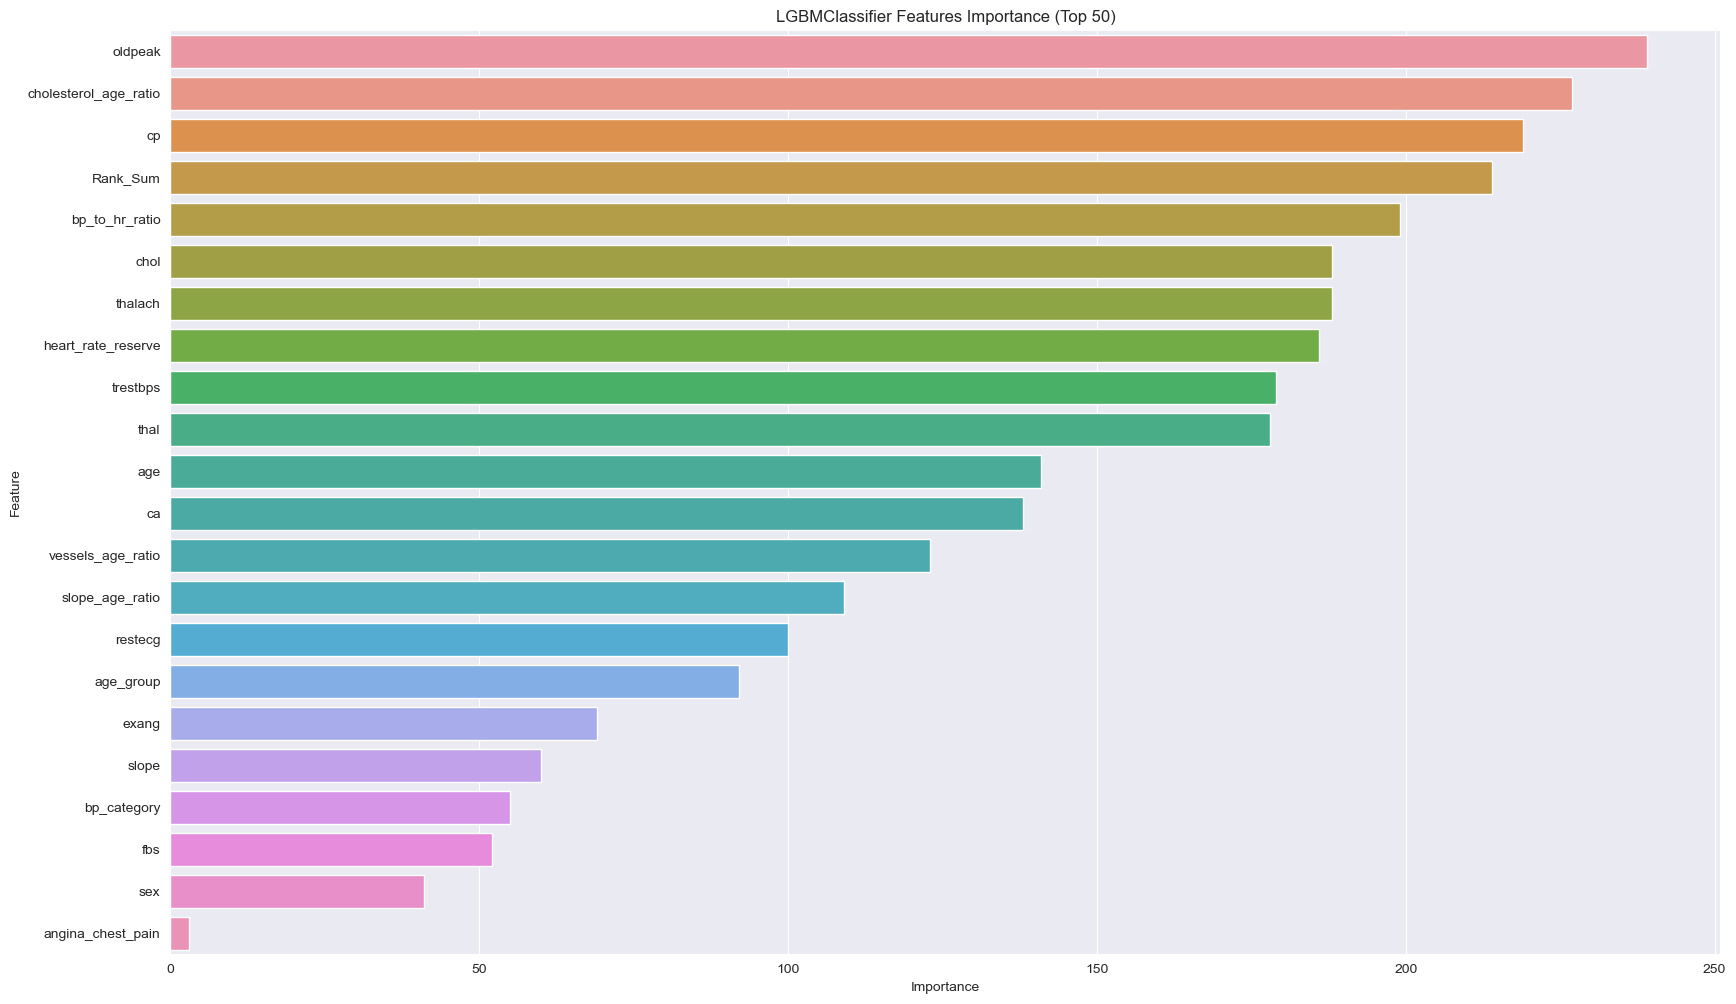

In [329]:


# Instantiate the GradientBoostingClassifier
classifier = lgb.LGBMClassifier(random_state=42, verbose=0)

# Fit the model
classifier.fit(X_train, y_train)

# Extract feature importances
feature_importance_df = pd.DataFrame(classifier.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns

# Plotting the top 50 feature importances
plt.figure(figsize=(20, 12))
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by='importance', ascending=False).head(50))
plt.title('LGBMClassifier Features Importance (Top 50)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


[shap values: https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability]

In [383]:


top_15_features = feature_importance_df.sort_values(by='importance', ascending=False).head(15)

# Display only the feature names of the top 15 columns
print("Top 15 Features:\n", top_15_features['feature'].tolist())

Top 15 Features:
 ['oldpeak', 'cholesterol_age_ratio', 'cp', 'Rank_Sum', 'bp_to_hr_ratio', 'chol', 'thalach', 'heart_rate_reserve', 'trestbps', 'thal', 'age', 'ca', 'vessels_age_ratio', 'slope_age_ratio', 'restecg']


In [384]:
train=train[['oldpeak', 'cholesterol_age_ratio', 'cp', 'Rank_Sum', 
'bp_to_hr_ratio', 'chol', 'thalach', 'heart_rate_reserve', 
'trestbps', 'thal', 'age', 'ca', 'vessels_age_ratio', 
'slope_age_ratio', 'restecg']]

In [428]:

test= test[['oldpeak', 'cholesterol_age_ratio', 'cp', 'Rank_Sum', 
'bp_to_hr_ratio', 'chol', 'thalach', 'heart_rate_reserve', 
'trestbps', 'thal', 'age', 'ca', 'vessels_age_ratio', 
'slope_age_ratio', 'restecg']]

### Use Optuna

In [ ]:
X = train.copy()
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    fold_pred=[]
    oof_pred = []


    param = {}
    param['objective'] = "binary"

    param["learning_rate"] = trial.suggest_float("learning_rate", 1e-2, 0.30, log=True)
    #param['reg_lambda'] = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    #param['reg_alpha'] = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    param['subsample'] = trial.suggest_float("subsample", 0.1, 1.0)
    param['colsample_bytree'] = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    param['max_depth'] = trial.suggest_int("max_depth", 20, 50)
    param['scale_pos_weight'] = trial.suggest_int('scale_pos_weight', 6,10)
    param['n_estimators'] = trial.suggest_int('n_estimators', 400,4000)




    fold=StratifiedKFold(n_splits=8,shuffle=True, random_state=42) #15#5#10
    i=1
    for train_index, test_index in fold.split(X,y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # m2 = CatBoostRegressor(**param)
        m2 = lgb.LGBMClassifier(**param, verbose=0)

        m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], callbacks=[log_evaluation(1200)])#erly100
        preds=m2.predict(X_test)
        oof_pred.append(f1_score(y_test,preds))

    return np.mean(oof_pred) 


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100) 

In [ ]:
# Retrieve the best trial
best_trial = study.best_trial

print(f"Best trial value (Validation Loss): {best_trial.value}")
print("Best hyperparameters found:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

predictions = []
scores = []
i=0

params = {'learning_rate': 0.02,
'subsample': 0.8,
'colsample_bytree': 0.1,
'max_depth': 5,
'scale_pos_weight': 6,
'n_estimators': 500,
'verbosity': -1
          }

fold=StratifiedKFold(n_splits=10,shuffle=True, random_state=1)

for train_index, test_index in fold.split(train,y):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    
    

    classifier2 = lgb.LGBMClassifier(**params, verbose=0)
    classifier2.fit(X_train, Y_train)
    
    preds=classifier2.predict(X_test)
    score = f1_score(Y_test,preds)
    scores.append(score)
    print("F1: ", score)
    predictions.append(classifier2.predict(test))
    i=i+1


print(np.mean(scores))

#Trial 652 finished with value: 0.9687548448537013 and parameters: {'learning_rate': 0.1805243125886494, 'subsample': 0.2128564969905326, 'colsample_bytree': 0.5046224462041669, 'max_depth': 13, 'scale_pos_weight': 6, 'n_estimators': 995}

### Make submission

In [444]:
#submit

### Random search Tuning Method

In [426]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
X = train.copy()

# Step 1: Define the parameter grid for Random Search
param_dist = {
    'learning_rate': np.linspace(0.01, 0.2, 20),
    'n_estimators': np.arange(100, 1001, 50),
    'max_depth': np.arange(3, 15, 1),
    'subsample': np.linspace(0.1, 1.0, 10),
    'colsample_bytree': np.linspace(0.1, 1.0, 10)
}

fold=StratifiedKFold(n_splits=8,shuffle=True, random_state=42) #15#5#10
i=1
for train_index, test_index in fold.split(X,y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # m2 = CatBoostRegressor(**param)
    random_search = RandomizedSearchCV(
    lgb.LGBMClassifier(verbose=0),
    param_distributions=param_dist,
    n_iter=100,  # Number of random samples
    cv=5,        # Cross-validation
    random_state=42,
    n_jobs=-1    # Use all available cores
)

    random_search.fit(X_train, y_train)

    # Get the best parameters from Random Search
    best_params = random_search.best_params_
    print("Best parameters from Random Search:")
    print(best_params)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Make predictions with RS best parameters 

In [430]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

predictions_rs = []
scores = []
i=0

params = {'learning_rate': 0.02,
'subsample': 0.8,
'colsample_bytree': 0.1,
'max_depth': 5,
'scale_pos_weight': 6,
'n_estimators': 500,
'verbosity': -1
          }

fold=StratifiedKFold(n_splits=10,shuffle=True, random_state=1)

for train_index, test_index in fold.split(train,y):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    
    

    classifier2 = lgb.LGBMClassifier(**params, verbose=0)
    classifier2.fit(X_train, Y_train)
    
    preds=classifier2.predict(X_test)
    score = f1_score(Y_test,preds)
    scores.append(score)
    print("F1: ", score)
    predictions_rs.append(classifier2.predict(test))
    i=i+1


print(np.mean(scores))

#Trial 652 finished with value: 0.9687548448537013 and parameters: {'learning_rate': 0.1805243125886494, 'subsample': 0.2128564969905326, 'colsample_bytree': 0.5046224462041669, 'max_depth': 13, 'scale_pos_weight': 6, 'n_estimators': 995}

F1:  0.8974358974358975
F1:  0.8966037735849056
F1:  0.8966037735849056
F1:  0.8972809667673716
F1:  0.8972809667673716
F1:  0.8972809667673716
F1:  0.8972809667673716
F1:  0.8972809667673716
F1:  0.8972809667673716
F1:  0.8972809667673716
0.897161021197731


### Make submission

In [431]:
# Aggregating predictions (e.g., majority voting if multiple predictions)
final_predictions = np.mean(predictions_rs, axis=0)
final_predictions = np.where(final_predictions > 0.5, 1, 0)

# Preparing for submission (if needed)
test_rs=pd.read_csv('Test Dataset.csv')
sub_rs = pd.DataFrame({'ID': test_rs['id'], 'target': final_predictions})
sub_rs.to_csv('win_rs.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


### Combine Randomsearch and Optuna

In [438]:
X = train.copy()
from lightgbm import early_stopping, log_evaluation

def objective(trial):
    fold_pred=[]
    oof_pred = []


    param = {}
    param['objective'] = "binary"

    param["learning_rate"] = trial.suggest_float('learning_rate', max(1e-3, best_params['learning_rate'] * 0.5), 
            min(1.0, best_params['learning_rate'] * 1.5))
    #param['reg_lambda'] = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    #param['reg_alpha'] = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    param['subsample'] = trial.suggest_float('subsample', max(0.1, best_params['subsample'] * 0.5), 
            min(1.0, best_params['subsample'] * 1.5))
    param['colsample_bytree'] = trial.suggest_float('colsample_bytree', max(0.1, best_params['colsample_bytree'] * 0.5), 
            min(1.0, best_params['colsample_bytree'] * 1.5))
    param['max_depth'] = trial.suggest_int('max_depth', max(3, best_params['max_depth'] - 2), 
            best_params['max_depth'] + 2)
    param['scale_pos_weight'] = trial.suggest_int('scale_pos_weight', 6,10)
    param['n_estimators'] = trial.suggest_int('n_estimators', max(100, best_params['n_estimators'] - 50), 
            best_params['n_estimators'] + 50)

   




    fold=StratifiedKFold(n_splits=8,shuffle=True, random_state=42) #15#5#10
    i=1
    for train_index, test_index in fold.split(X,y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # m2 = CatBoostRegressor(**param)
        m2 = lgb.LGBMClassifier(**param, verbose=-1)

        m2.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], callbacks=[log_evaluation(1200)])#erly100
        preds=m2.predict(X_test)
        oof_pred.append(f1_score(y_test,preds))

    return np.mean(oof_pred) 


In [439]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100) 



[I 2024-09-24 16:11:25,347] A new study created in memory with name: no-name-13db8885-fbec-4445-9c6a-ba85999b9a7e
[I 2024-09-24 16:11:36,281] Trial 0 finished with value: 0.8971609141909 and parameters: {'learning_rate': 0.029628267510170232, 'subsample': 0.5525720809882995, 'colsample_bytree': 0.11651471845711506, 'max_depth': 5, 'scale_pos_weight': 6, 'n_estimators': 545}. Best is trial 0 with value: 0.8971609141909.
[I 2024-09-24 16:11:50,860] Trial 1 finished with value: 0.8971609141909 and parameters: {'learning_rate': 0.013832031868981114, 'subsample': 0.8078180221524272, 'colsample_bytree': 0.11178844539620642, 'max_depth': 6, 'scale_pos_weight': 10, 'n_estimators': 496}. Best is trial 0 with value: 0.8971609141909.
[I 2024-09-24 16:11:55,579] Trial 2 finished with value: 0.8971609141909 and parameters: {'learning_rate': 0.019329517010623975, 'subsample': 0.7238226235353034, 'colsample_bytree': 0.10428291986253563, 'max_depth': 3, 'scale_pos_weight': 6, 'n_estimators': 527}. Bes

In [440]:
# Retrieve the best trial
best_trial = study.best_trial

print(f"Best trial value (Validation Loss): {best_trial.value}")
print("Best hyperparameters found:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

Best trial value (Validation Loss): 0.8971609141909
Best hyperparameters found:
learning_rate: 0.029628267510170232
subsample: 0.5525720809882995
colsample_bytree: 0.11651471845711506
max_depth: 5
scale_pos_weight: 6
n_estimators: 545


### Make predictions with the combination of RS and Optuna

In [441]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

predictions_rsop = []
scores = []
i=0

params = {'learning_rate': 0.029628267510170232,
'subsample': 0.5525720809882995,
'colsample_bytree': 0.11651471845711506,
'max_depth': 5,
'scale_pos_weight': 6,
'n_estimators': 545
          }

fold=StratifiedKFold(n_splits=10,shuffle=True, random_state=1)

for train_index, test_index in fold.split(train,y):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

    
    

    classifier2 = lgb.LGBMClassifier(**params, verbose=-1)
    classifier2.fit(X_train, Y_train)
    
    preds=classifier2.predict(X_test)
    score = f1_score(Y_test,preds)
    scores.append(score)
    print("F1: ", score)
    predictions_rsop.append(classifier2.predict(test))
    i=i+1


print(np.mean(scores))

#Trial 652 finished with value: 0.9687548448537013 and parameters: {'learning_rate': 0.1805243125886494, 'subsample': 0.2128564969905326, 'colsample_bytree': 0.5046224462041669, 'max_depth': 13, 'scale_pos_weight': 6, 'n_estimators': 995}

F1:  0.8974358974358975
F1:  0.8966037735849056
F1:  0.8966037735849056
F1:  0.8972809667673716
F1:  0.8972809667673716
F1:  0.8972809667673716
F1:  0.8972809667673716
F1:  0.8972809667673716
F1:  0.8972809667673716
F1:  0.8972809667673716
0.897161021197731


### Make Submission

In [443]:
# Aggregating predictions (e.g., majority voting if multiple predictions)
final_predictions = np.mean(predictions_rsop, axis=0)
final_predictions = np.where(final_predictions > 0.5, 1, 0)

# Preparing for submission (if needed)
testdata=pd.read_csv('Test Dataset.csv')
sub_rsop = pd.DataFrame({'ID': testdata['id'], 'target': final_predictions})
sub_rsop.to_csv('win_rsop.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


### Use Neural Network

In [447]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import f1_score
import tensorflow as tf

def objective(trial):
    fold_pred = []
    oof_pred = []

    # Hyperparameter search space
    units1 = trial.suggest_int("units1", 32, 128)
    units2 = trial.suggest_int("units2", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    activation1 = trial.suggest_categorical("activation1", ["relu", "tanh", "sigmoid"])
    activation2 = trial.suggest_categorical("activation2", ["relu", "tanh", "sigmoid"])
    batch_size = trial.suggest_int("batch_size", 16, 64)
    epochs = trial.suggest_int("epochs", 10, 50)

    fold = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)  # Adjust n_splits as needed

    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Create the neural network model
        model = Sequential([
            Dense(units1, activation=activation1, input_shape=(X_train.shape[1],)),
            Dropout(dropout_rate),
            Dense(units2, activation=activation2),
            Dense(1, activation='sigmoid')  # For binary classification
        ])

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                      loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model with evaluation set
        model.fit(X_train, y_train, 
                  validation_data=(X_test, y_test),  # Use test set as validation set
                  epochs=epochs, 
                  batch_size=batch_size, 
                  verbose=0)  # Set verbose=0 to silence output
        
        preds = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary predictions
        fold_pred.append(f1_score(y_test, preds))

    return np.mean(fold_pred)  # Return the average F1 score over all folds


In [448]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100) 

[I 2024-09-25 01:23:52,742] A new study created in memory with name: no-name-8ddddfde-4e46-4dd0-a10b-9a1db99978e8


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 01:28:45,429] Trial 0 finished with value: 0.8971609141909 and parameters: {'units1': 50, 'units2': 75, 'dropout_rate': 0.23212026912017683, 'learning_rate': 0.000351999395296267, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 19, 'epochs': 31}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 01:31:18,335] Trial 1 finished with value: 0.8971609141909 and parameters: {'units1': 107, 'units2': 43, 'dropout_rate': 0.35558933226416234, 'learning_rate': 7.828059823799994e-05, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 42, 'epochs': 36}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 01:35:16,307] Trial 2 finished with value: 0.8971609141909 and parameters: {'units1': 108, 'units2': 124, 'dropout_rate': 0.16251746922388588, 'learning_rate': 0.0006128543939250452, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 23, 'epochs': 34}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 4ms/step


[I 2024-09-25 01:40:58,753] Trial 3 finished with value: 0.8971609141909 and parameters: {'units1': 97, 'units2': 48, 'dropout_rate': 0.23422177397765528, 'learning_rate': 0.00025853491085397193, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 21, 'epochs': 46}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 01:46:24,631] Trial 4 finished with value: 0.8971609141909 and parameters: {'units1': 40, 'units2': 112, 'dropout_rate': 0.307249945082964, 'learning_rate': 0.00019071325251411884, 'activation1': 'tanh', 'activation2': 'relu', 'batch_size': 17, 'epochs': 35}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 01:48:04,958] Trial 5 finished with value: 0.8917612399059606 and parameters: {'units1': 36, 'units2': 92, 'dropout_rate': 0.15568076125523814, 'learning_rate': 0.0004799006187816481, 'activation1': 'relu', 'activation2': 'relu', 'batch_size': 51, 'epochs': 21}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 01:50:31,403] Trial 6 finished with value: 0.8971609141909 and parameters: {'units1': 126, 'units2': 76, 'dropout_rate': 0.43107954486823963, 'learning_rate': 0.018416003889166987, 'activation1': 'relu', 'activation2': 'sigmoid', 'batch_size': 22, 'epochs': 22}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 01:51:44,011] Trial 7 finished with value: 0.8971609141909 and parameters: {'units1': 112, 'units2': 44, 'dropout_rate': 0.14099993026012775, 'learning_rate': 1.9124898340788458e-05, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 53, 'epochs': 19}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 01:56:02,735] Trial 8 finished with value: 0.89707763193978 and parameters: {'units1': 64, 'units2': 126, 'dropout_rate': 0.2873902214795385, 'learning_rate': 0.0004084488183371958, 'activation1': 'relu', 'activation2': 'relu', 'batch_size': 27, 'epochs': 42}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 01:58:40,457] Trial 9 finished with value: 0.8971609141909 and parameters: {'units1': 41, 'units2': 42, 'dropout_rate': 0.1276711847452084, 'learning_rate': 0.000295125197913056, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 57, 'epochs': 43}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 01:59:39,897] Trial 10 finished with value: 0.8971609141909 and parameters: {'units1': 65, 'units2': 74, 'dropout_rate': 0.42498719314421873, 'learning_rate': 0.006877969040508156, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 34, 'epochs': 10}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:01:31,674] Trial 11 finished with value: 0.8971609141909 and parameters: {'units1': 79, 'units2': 63, 'dropout_rate': 0.3515555138700255, 'learning_rate': 2.7287238723735293e-05, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 43, 'epochs': 30}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:03:37,512] Trial 12 finished with value: 0.8971609141909 and parameters: {'units1': 92, 'units2': 93, 'dropout_rate': 0.23501841752775024, 'learning_rate': 0.002895221977894937, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 41, 'epochs': 31}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:06:18,070] Trial 13 finished with value: 0.8971609141909 and parameters: {'units1': 59, 'units2': 60, 'dropout_rate': 0.3761944713595094, 'learning_rate': 6.0369743318650166e-05, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 33, 'epochs': 38}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:07:53,822] Trial 14 finished with value: 0.8971609141909 and parameters: {'units1': 84, 'units2': 34, 'dropout_rate': 0.2347298071773568, 'learning_rate': 0.09929964725968884, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 47, 'epochs': 26}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:10:14,947] Trial 15 finished with value: 0.8971609141909 and parameters: {'units1': 51, 'units2': 93, 'dropout_rate': 0.4763308357364379, 'learning_rate': 5.5500842926456215e-05, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 63, 'epochs': 50}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:12:27,387] Trial 16 finished with value: 0.8971609141909 and parameters: {'units1': 123, 'units2': 59, 'dropout_rate': 0.2988696942265964, 'learning_rate': 0.0021080696260051606, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 32, 'epochs': 27}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:14:54,951] Trial 17 finished with value: 0.8971609141909 and parameters: {'units1': 82, 'units2': 32, 'dropout_rate': 0.20176126301048383, 'learning_rate': 9.469876622415633e-05, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 37, 'epochs': 38}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:16:11,651] Trial 18 finished with value: 0.8971609141909 and parameters: {'units1': 105, 'units2': 104, 'dropout_rate': 0.33230956258302397, 'learning_rate': 1.2470468871284501e-05, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 29, 'epochs': 13}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:17:51,914] Trial 19 finished with value: 0.8971609141909 and parameters: {'units1': 74, 'units2': 69, 'dropout_rate': 0.3985810421205009, 'learning_rate': 0.0014145406881445383, 'activation1': 'relu', 'activation2': 'relu', 'batch_size': 44, 'epochs': 26}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:20:06,484] Trial 20 finished with value: 0.8971609141909 and parameters: {'units1': 49, 'units2': 52, 'dropout_rate': 0.2618326010027371, 'learning_rate': 0.00011528342913377901, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 38, 'epochs': 35}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:23:39,796] Trial 21 finished with value: 0.8971609141909 and parameters: {'units1': 114, 'units2': 125, 'dropout_rate': 0.1674363794678507, 'learning_rate': 0.0006909708149058929, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 23, 'epochs': 33}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:28:04,223] Trial 22 finished with value: 0.8971609141909 and parameters: {'units1': 102, 'units2': 112, 'dropout_rate': 0.10553194850480346, 'learning_rate': 0.0010267653333487815, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 18, 'epochs': 39}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:31:18,089] Trial 23 finished with value: 0.8971609141909 and parameters: {'units1': 116, 'units2': 85, 'dropout_rate': 0.18870978346990663, 'learning_rate': 0.005469424594334248, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 27, 'epochs': 34}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 02:35:37,876] Trial 24 finished with value: 0.8971609141909 and parameters: {'units1': 93, 'units2': 102, 'dropout_rate': 0.20502699855344264, 'learning_rate': 4.305162605442419e-05, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 16, 'epochs': 28}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:39:42,226] Trial 25 finished with value: 0.8971609141909 and parameters: {'units1': 103, 'units2': 86, 'dropout_rate': 0.2670009774173101, 'learning_rate': 0.00016106126076606382, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 25, 'epochs': 40}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:44:53,759] Trial 26 finished with value: 0.8971609141909 and parameters: {'units1': 89, 'units2': 68, 'dropout_rate': 0.3439820341854674, 'learning_rate': 0.0006871074248786332, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 20, 'epochs': 32}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:48:26,378] Trial 27 finished with value: 0.8971609141909 and parameters: {'units1': 110, 'units2': 117, 'dropout_rate': 0.1811732403166253, 'learning_rate': 8.610559007366684e-05, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 30, 'epochs': 45}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 02:50:32,355] Trial 28 finished with value: 0.8971609141909 and parameters: {'units1': 73, 'units2': 38, 'dropout_rate': 0.4947060776610121, 'learning_rate': 0.0038784558250998516, 'activation1': 'relu', 'activation2': 'relu', 'batch_size': 48, 'epochs': 36}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:52:28,176] Trial 29 finished with value: 0.8971609141909 and parameters: {'units1': 97, 'units2': 53, 'dropout_rate': 0.21537930259508833, 'learning_rate': 0.00024603703949171415, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 35, 'epochs': 24}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 02:57:54,998] Trial 30 finished with value: 0.8971609141909 and parameters: {'units1': 120, 'units2': 100, 'dropout_rate': 0.26447966014816054, 'learning_rate': 0.026995204340175088, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 20, 'epochs': 49}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 03:03:32,547] Trial 31 finished with value: 0.8971609141909 and parameters: {'units1': 98, 'units2': 50, 'dropout_rate': 0.3038820887183714, 'learning_rate': 0.00020077525504394626, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 17, 'epochs': 46}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 03:07:44,564] Trial 32 finished with value: 0.8971609141909 and parameters: {'units1': 107, 'units2': 45, 'dropout_rate': 0.24425467985938168, 'learning_rate': 0.0005368386045799144, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 24, 'epochs': 36}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 03:11:53,521] Trial 33 finished with value: 0.8971609141909 and parameters: {'units1': 33, 'units2': 55, 'dropout_rate': 0.16341995261993522, 'learning_rate': 0.0003014787109663654, 'activation1': 'tanh', 'activation2': 'relu', 'batch_size': 22, 'epochs': 29}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 5ms/step


[I 2024-09-25 03:20:20,633] Trial 34 finished with value: 0.8971609141909 and parameters: {'units1': 118, 'units2': 80, 'dropout_rate': 0.31840281997940695, 'learning_rate': 0.001448136387256067, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 19, 'epochs': 47}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 4ms/step


[I 2024-09-25 03:26:32,245] Trial 35 finished with value: 0.8971609141909 and parameters: {'units1': 128, 'units2': 46, 'dropout_rate': 0.13875321927209727, 'learning_rate': 3.0645842115373455e-05, 'activation1': 'relu', 'activation2': 'sigmoid', 'batch_size': 26, 'epochs': 42}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 03:28:38,319] Trial 36 finished with value: 0.8971609141909 and parameters: {'units1': 88, 'units2': 37, 'dropout_rate': 0.21870706145907495, 'learning_rate': 0.0001322719049901442, 'activation1': 'tanh', 'activation2': 'relu', 'batch_size': 54, 'epochs': 22}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 5ms/step


[I 2024-09-25 03:34:31,153] Trial 37 finished with value: 0.8971609141909 and parameters: {'units1': 110, 'units2': 69, 'dropout_rate': 0.2804339203305448, 'learning_rate': 0.00035961079145928, 'activation1': 'relu', 'activation2': 'tanh', 'batch_size': 30, 'epochs': 44}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 8ms/step


[I 2024-09-25 03:39:34,937] Trial 38 finished with value: 0.8971609141909 and parameters: {'units1': 99, 'units2': 76, 'dropout_rate': 0.3846860933305686, 'learning_rate': 0.000494047297429003, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 16, 'epochs': 19}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 4ms/step


[I 2024-09-25 03:46:27,840] Trial 39 finished with value: 0.8971609141909 and parameters: {'units1': 75, 'units2': 41, 'dropout_rate': 0.10285112605962482, 'learning_rate': 0.0008840362030765494, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 21, 'epochs': 41}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 1s 6ms/step


[I 2024-09-25 03:51:22,430] Trial 40 finished with value: 0.8971609141909 and parameters: {'units1': 41, 'units2': 62, 'dropout_rate': 0.35793690302942277, 'learning_rate': 0.00020246497103015306, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 38, 'epochs': 32}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 4ms/step


[I 2024-09-25 03:58:06,904] Trial 41 finished with value: 0.8971609141909 and parameters: {'units1': 42, 'units2': 121, 'dropout_rate': 0.3063061586820873, 'learning_rate': 0.0003789820295754655, 'activation1': 'tanh', 'activation2': 'relu', 'batch_size': 23, 'epochs': 37}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 4ms/step


[I 2024-09-25 04:03:38,520] Trial 42 finished with value: 0.8971609141909 and parameters: {'units1': 58, 'units2': 106, 'dropout_rate': 0.42117799904828335, 'learning_rate': 7.260987662404933e-05, 'activation1': 'tanh', 'activation2': 'relu', 'batch_size': 19, 'epochs': 30}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 4ms/step


[I 2024-09-25 04:07:00,878] Trial 43 finished with value: 0.8971609141909 and parameters: {'units1': 47, 'units2': 128, 'dropout_rate': 0.2447557936892299, 'learning_rate': 0.0001507153363229626, 'activation1': 'sigmoid', 'activation2': 'relu', 'batch_size': 42, 'epochs': 34}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 4ms/step


[I 2024-09-25 04:10:20,759] Trial 44 finished with value: 0.8971609141909 and parameters: {'units1': 36, 'units2': 114, 'dropout_rate': 0.3213017052500213, 'learning_rate': 4.2919208516654234e-05, 'activation1': 'tanh', 'activation2': 'relu', 'batch_size': 46, 'epochs': 31}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 4ms/step


[I 2024-09-25 04:14:35,388] Trial 45 finished with value: 0.8971609141909 and parameters: {'units1': 66, 'units2': 123, 'dropout_rate': 0.14960057075514124, 'learning_rate': 1.6376389176467298e-05, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 50, 'epochs': 39}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 8ms/step


[I 2024-09-25 04:20:30,791] Trial 46 finished with value: 0.8971609141909 and parameters: {'units1': 54, 'units2': 109, 'dropout_rate': 0.28716132683996753, 'learning_rate': 0.0018303622132486888, 'activation1': 'tanh', 'activation2': 'relu', 'batch_size': 27, 'epochs': 43}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 5ms/step


[I 2024-09-25 04:24:37,749] Trial 47 finished with value: 0.8971609141909 and parameters: {'units1': 122, 'units2': 119, 'dropout_rate': 0.36906926056831396, 'learning_rate': 0.00024557099859251686, 'activation1': 'relu', 'activation2': 'sigmoid', 'batch_size': 40, 'epochs': 35}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 1s 11ms/step


[I 2024-09-25 04:27:02,631] Trial 48 finished with value: 0.8971609141909 and parameters: {'units1': 45, 'units2': 89, 'dropout_rate': 0.3352271296129742, 'learning_rate': 2.3904902375686272e-05, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 60, 'epochs': 24}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 5ms/step


[I 2024-09-25 04:32:25,897] Trial 49 finished with value: 0.8971609141909 and parameters: {'units1': 38, 'units2': 57, 'dropout_rate': 0.12361372264325647, 'learning_rate': 0.00010142627432721748, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 21, 'epochs': 29}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 5ms/step


[I 2024-09-25 04:36:17,242] Trial 50 finished with value: 0.8971609141909 and parameters: {'units1': 32, 'units2': 98, 'dropout_rate': 0.2304616637709836, 'learning_rate': 0.010707097819264473, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 16, 'epochs': 16}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 1s 19ms/step


[I 2024-09-25 04:38:36,221] Trial 51 finished with value: 0.8971609141909 and parameters: {'units1': 126, 'units2': 78, 'dropout_rate': 0.4369742811816119, 'learning_rate': 0.06689288421086331, 'activation1': 'relu', 'activation2': 'sigmoid', 'batch_size': 24, 'epochs': 10}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 5ms/step


[I 2024-09-25 04:45:56,243] Trial 52 finished with value: 0.8971609141909 and parameters: {'units1': 114, 'units2': 72, 'dropout_rate': 0.4506963317831465, 'learning_rate': 0.011174745473322813, 'activation1': 'relu', 'activation2': 'sigmoid', 'batch_size': 18, 'epochs': 33}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 5ms/step


[I 2024-09-25 04:50:44,325] Trial 53 finished with value: 0.8971609141909 and parameters: {'units1': 85, 'units2': 96, 'dropout_rate': 0.46849985683409145, 'learning_rate': 0.0008969164050336834, 'activation1': 'relu', 'activation2': 'sigmoid', 'batch_size': 28, 'epochs': 25}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 4ms/step


[I 2024-09-25 04:53:10,808] Trial 54 finished with value: 0.8971609141909 and parameters: {'units1': 93, 'units2': 65, 'dropout_rate': 0.39043779498733183, 'learning_rate': 0.0004771503516209568, 'activation1': 'relu', 'activation2': 'sigmoid', 'batch_size': 32, 'epochs': 16}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 5ms/step


[I 2024-09-25 04:58:32,012] Trial 55 finished with value: 0.8971609141909 and parameters: {'units1': 106, 'units2': 49, 'dropout_rate': 0.4082178744136169, 'learning_rate': 0.0006668931680490489, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 22, 'epochs': 27}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 5ms/step


[I 2024-09-25 05:02:46,078] Trial 56 finished with value: 0.8971609141909 and parameters: {'units1': 112, 'units2': 85, 'dropout_rate': 0.18055869253361892, 'learning_rate': 0.003063279595716513, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 25, 'epochs': 22}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 05:05:59,377] Trial 57 finished with value: 0.8971609141909 and parameters: {'units1': 100, 'units2': 74, 'dropout_rate': 0.27729506155531963, 'learning_rate': 0.037887769746957914, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 35, 'epochs': 38}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 09:51:25,576] Trial 58 finished with value: 0.8964095574131485 and parameters: {'units1': 68, 'units2': 80, 'dropout_rate': 0.24938247979831868, 'learning_rate': 5.74503661186687e-05, 'activation1': 'relu', 'activation2': 'relu', 'batch_size': 44, 'epochs': 48}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 09:56:31,690] Trial 59 finished with value: 0.89707763193978 and parameters: {'units1': 124, 'units2': 115, 'dropout_rate': 0.19636562662485885, 'learning_rate': 0.0001848866572571235, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 18, 'epochs': 31}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:00:50,747] Trial 60 finished with value: 0.8971609141909 and parameters: {'units1': 79, 'units2': 33, 'dropout_rate': 0.3579090302944342, 'learning_rate': 0.0003251436999928873, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 21, 'epochs': 36}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 10:02:22,975] Trial 61 finished with value: 0.8971609141909 and parameters: {'units1': 117, 'units2': 41, 'dropout_rate': 0.11729672665606601, 'learning_rate': 0.001224263657752796, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 53, 'epochs': 20}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 10:03:41,122] Trial 62 finished with value: 0.8971609141909 and parameters: {'units1': 104, 'units2': 45, 'dropout_rate': 0.13825951744103565, 'learning_rate': 1.2358214161112322e-05, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 59, 'epochs': 17}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:05:06,194] Trial 63 finished with value: 0.8971609141909 and parameters: {'units1': 109, 'units2': 49, 'dropout_rate': 0.15183061508003534, 'learning_rate': 1.7877792785226296e-05, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 56, 'epochs': 18}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 10:10:35,297] Trial 64 finished with value: 0.8971609141909 and parameters: {'units1': 96, 'units2': 62, 'dropout_rate': 0.21338143689933284, 'learning_rate': 4.447448211758623e-05, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 20, 'epochs': 33}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:11:49,630] Trial 65 finished with value: 0.8971609141909 and parameters: {'units1': 120, 'units2': 38, 'dropout_rate': 0.16584915111243817, 'learning_rate': 0.00025593761350156755, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 63, 'epochs': 13}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 10:15:38,267] Trial 66 finished with value: 0.8971609141909 and parameters: {'units1': 115, 'units2': 90, 'dropout_rate': 0.2269161344972822, 'learning_rate': 0.00010501703980040183, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 23, 'epochs': 23}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 10:21:10,984] Trial 67 finished with value: 0.8971609141909 and parameters: {'units1': 112, 'units2': 57, 'dropout_rate': 0.18695028620557375, 'learning_rate': 7.585369095600206e-05, 'activation1': 'tanh', 'activation2': 'relu', 'batch_size': 17, 'epochs': 27}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:24:45,736] Trial 68 finished with value: 0.8969109667334874 and parameters: {'units1': 52, 'units2': 35, 'dropout_rate': 0.3148960981975036, 'learning_rate': 1.0060829803522777e-05, 'activation1': 'relu', 'activation2': 'tanh', 'batch_size': 50, 'epochs': 40}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:29:10,466] Trial 69 finished with value: 0.8971609141909 and parameters: {'units1': 102, 'units2': 83, 'dropout_rate': 0.4983062093534685, 'learning_rate': 3.0412596530499703e-05, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 30, 'epochs': 50}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:32:54,420] Trial 70 finished with value: 0.8971609141909 and parameters: {'units1': 108, 'units2': 67, 'dropout_rate': 0.34142968613856817, 'learning_rate': 0.0001375334333424628, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 25, 'epochs': 35}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 1ms/step


[I 2024-09-25 10:35:21,013] Trial 71 finished with value: 0.8971609141909 and parameters: {'units1': 42, 'units2': 42, 'dropout_rate': 0.11595860409639741, 'learning_rate': 0.00041375428577471846, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 57, 'epochs': 45}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:37:46,010] Trial 72 finished with value: 0.8971609141909 and parameters: {'units1': 37, 'units2': 47, 'dropout_rate': 0.1351180554328, 'learning_rate': 0.00027205749204141887, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 53, 'epochs': 42}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:40:09,334] Trial 73 finished with value: 0.8971609141909 and parameters: {'units1': 49, 'units2': 52, 'dropout_rate': 0.1753430365738628, 'learning_rate': 0.0007653392004548484, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 46, 'epochs': 37}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 1ms/step


[I 2024-09-25 10:42:36,210] Trial 74 finished with value: 0.8971609141909 and parameters: {'units1': 39, 'units2': 42, 'dropout_rate': 0.25468035561631064, 'learning_rate': 0.0005765508407397476, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 59, 'epochs': 47}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:44:27,498] Trial 75 finished with value: 0.8971609141909 and parameters: {'units1': 45, 'units2': 126, 'dropout_rate': 0.2965597077553655, 'learning_rate': 0.0001682853248978945, 'activation1': 'tanh', 'activation2': 'relu', 'batch_size': 55, 'epochs': 29}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 1ms/step


[I 2024-09-25 10:48:33,159] Trial 76 finished with value: 0.8971609141909 and parameters: {'units1': 56, 'units2': 109, 'dropout_rate': 0.12371247241250669, 'learning_rate': 0.0002094008024147581, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 19, 'epochs': 32}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:52:09,954] Trial 77 finished with value: 0.8971609141909 and parameters: {'units1': 35, 'units2': 38, 'dropout_rate': 0.27391503798632755, 'learning_rate': 0.0004116979246333556, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 32, 'epochs': 43}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:55:03,146] Trial 78 finished with value: 0.8971609141909 and parameters: {'units1': 62, 'units2': 54, 'dropout_rate': 0.1486853630838693, 'learning_rate': 0.00011797743008147414, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 40, 'epochs': 34}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 7ms/step


[I 2024-09-25 10:57:25,476] Trial 79 finished with value: 0.8971609141909 and parameters: {'units1': 95, 'units2': 72, 'dropout_rate': 0.20348510708336723, 'learning_rate': 0.0017239398100492305, 'activation1': 'relu', 'activation2': 'relu', 'batch_size': 17, 'epochs': 14}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 10:59:32,787] Trial 80 finished with value: 0.8971609141909 and parameters: {'units1': 90, 'units2': 45, 'dropout_rate': 0.3273752167119997, 'learning_rate': 0.00031883805130334357, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 61, 'epochs': 39}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 11:00:32,057] Trial 81 finished with value: 0.8971609141909 and parameters: {'units1': 46, 'units2': 77, 'dropout_rate': 0.42345221814046524, 'learning_rate': 0.023343498548702397, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 36, 'epochs': 10}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:02:07,406] Trial 82 finished with value: 0.8971609141909 and parameters: {'units1': 120, 'units2': 72, 'dropout_rate': 0.4492370330754707, 'learning_rate': 0.042398040075416615, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 22, 'epochs': 12}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:04:57,499] Trial 83 finished with value: 0.8971609141909 and parameters: {'units1': 62, 'units2': 35, 'dropout_rate': 0.37486581831315235, 'learning_rate': 0.006949572270409389, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 27, 'epochs': 30}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:07:25,200] Trial 84 finished with value: 0.8971609141909 and parameters: {'units1': 84, 'units2': 81, 'dropout_rate': 0.4034822031643095, 'learning_rate': 0.022401342220667007, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 20, 'epochs': 20}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 11:10:41,089] Trial 85 finished with value: 0.8971609141909 and parameters: {'units1': 102, 'units2': 60, 'dropout_rate': 0.48113135200401214, 'learning_rate': 0.015060351062392653, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 34, 'epochs': 37}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:13:26,799] Trial 86 finished with value: 0.8971609141909 and parameters: {'units1': 69, 'units2': 123, 'dropout_rate': 0.4593815820600128, 'learning_rate': 0.0005480608319718557, 'activation1': 'sigmoid', 'activation2': 'sigmoid', 'batch_size': 24, 'epochs': 26}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:17:24,069] Trial 87 finished with value: 0.8971609141909 and parameters: {'units1': 40, 'units2': 75, 'dropout_rate': 0.41956267344538695, 'learning_rate': 0.0010813918708170718, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 29, 'epochs': 46}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:19:53,150] Trial 88 finished with value: 0.8971609141909 and parameters: {'units1': 76, 'units2': 66, 'dropout_rate': 0.29307276474810706, 'learning_rate': 0.008059617692226033, 'activation1': 'relu', 'activation2': 'relu', 'batch_size': 49, 'epochs': 41}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:22:25,610] Trial 89 finished with value: 0.8971609141909 and parameters: {'units1': 128, 'units2': 40, 'dropout_rate': 0.16026220810805003, 'learning_rate': 0.0029015571881578803, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 38, 'epochs': 34}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 6ms/step


[I 2024-09-25 11:24:14,616] Trial 90 finished with value: 0.8971609141909 and parameters: {'units1': 111, 'units2': 103, 'dropout_rate': 0.4301722681499138, 'learning_rate': 0.004201954061666224, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 64, 'epochs': 28}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:26:09,230] Trial 91 finished with value: 0.8971609141909 and parameters: {'units1': 78, 'units2': 63, 'dropout_rate': 0.3599393370687304, 'learning_rate': 1.9952819455514446e-05, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 44, 'epochs': 30}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:28:19,442] Trial 92 finished with value: 0.8971609141909 and parameters: {'units1': 87, 'units2': 69, 'dropout_rate': 0.12967289718397787, 'learning_rate': 4.756658535877066e-05, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 43, 'epochs': 31}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:30:46,857] Trial 93 finished with value: 0.8971609141909 and parameters: {'units1': 106, 'units2': 43, 'dropout_rate': 0.34880253806707323, 'learning_rate': 7.191451372447792e-05, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 40, 'epochs': 35}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:32:56,230] Trial 94 finished with value: 0.8971609141909 and parameters: {'units1': 48, 'units2': 78, 'dropout_rate': 0.39441603845594353, 'learning_rate': 2.5697204443404932e-05, 'activation1': 'sigmoid', 'activation2': 'tanh', 'batch_size': 42, 'epochs': 32}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 11:39:57,051] Trial 95 finished with value: 0.8971609141909 and parameters: {'units1': 73, 'units2': 47, 'dropout_rate': 0.10020496451403432, 'learning_rate': 3.149553812260448e-05, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 19, 'epochs': 49}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:42:12,822] Trial 96 finished with value: 0.8971609141909 and parameters: {'units1': 43, 'units2': 51, 'dropout_rate': 0.41101298916565865, 'learning_rate': 1.3462943943974229e-05, 'activation1': 'relu', 'activation2': 'tanh', 'batch_size': 47, 'epochs': 38}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:43:40,678] Trial 97 finished with value: 0.8971609141909 and parameters: {'units1': 81, 'units2': 87, 'dropout_rate': 0.23867207953679104, 'learning_rate': 9.452536255091016e-05, 'activation1': 'sigmoid', 'activation2': 'relu', 'batch_size': 57, 'epochs': 25}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 2ms/step


[I 2024-09-25 11:45:37,021] Trial 98 finished with value: 0.8971609141909 and parameters: {'units1': 51, 'units2': 58, 'dropout_rate': 0.30883605870083336, 'learning_rate': 0.0002230991614919883, 'activation1': 'tanh', 'activation2': 'sigmoid', 'batch_size': 21, 'epochs': 15}. Best is trial 0 with value: 0.8971609141909.


29/29 [==============================] - 0s 3ms/step


[I 2024-09-25 11:48:27,050] Trial 99 finished with value: 0.8971609141909 and parameters: {'units1': 114, 'units2': 32, 'dropout_rate': 0.4410245360078482, 'learning_rate': 0.09217346685192589, 'activation1': 'tanh', 'activation2': 'tanh', 'batch_size': 17, 'epochs': 21}. Best is trial 0 with value: 0.8971609141909.


In [449]:
# Retrieve the best trial
best_trial = study.best_trial

print(f"Best trial value (Validation Loss): {best_trial.value}")
print("Best hyperparameters found:")
for key, value in best_trial.params.items():
    print(f"{key}: {value}")

Best trial value (Validation Loss): 0.8971609141909
Best hyperparameters found:
units1: 50
units2: 75
dropout_rate: 0.23212026912017683
learning_rate: 0.000351999395296267
activation1: tanh
activation2: sigmoid
batch_size: 19
epochs: 31


In [451]:


predictions_ann = []
scores = []
i=0

fold=StratifiedKFold(n_splits=10,shuffle=True, random_state=1)

for train_index, test_index in fold.split(train,y):
    X_train, X_test = train.iloc[train_index], train.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]


    model = Sequential([
            Dense(50, activation='tanh', input_shape=(X_train.shape[1],)),
            Dropout(0.23212026912017683),
            Dense(75, activation='sigmoid'),
            Dense(1, activation='sigmoid')  # For binary classification
        ])

        # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000351999395296267), 
                      loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model with evaluation set
    model.fit(X_train, Y_train, 
                  validation_data=(X_test, Y_test),  # Use test set as validation set
                  epochs=31, 
                  batch_size=19, 
                  verbose=0)  # Set verbose=0 to silence output
        
    preds = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary predictions
    score = f1_score(Y_test,preds)
    scores.append(score)
    print("F1: ", score)
    predictions_ann.append(classifier2.predict(test))
    i=i+1
print(np.mean(scores))

#Trial 652 finished with value: 0.9687548448537013 and parameters: {'learning_rate': 0.1805243125886494, 'subsample': 0.2128564969905326, 'colsample_bytree': 0.5046224462041669, 'max_depth': 13, 'scale_pos_weight': 6, 'n_estimators': 995}

23/23 [==============================] - 0s 3ms/step
F1:  0.8974358974358975
23/23 [==============================] - 0s 2ms/step
F1:  0.8966037735849056
23/23 [==============================] - 0s 3ms/step
F1:  0.8966037735849056
23/23 [==============================] - 0s 3ms/step
F1:  0.8972809667673716
23/23 [==============================] - 0s 4ms/step
F1:  0.8972809667673716
23/23 [==============================] - 1s 36ms/step
F1:  0.8972809667673716
23/23 [==============================] - 0s 2ms/step
F1:  0.8972809667673716
23/23 [==============================] - 0s 2ms/step
F1:  0.8972809667673716
23/23 [==============================] - 0s 3ms/step
F1:  0.8972809667673716
23/23 [==============================] - 0s 3ms/step
F1:  0.8972809667673716
0.897161021197731


In [453]:
# Aggregating predictions (e.g., majority voting if multiple predictions)
final_predictions = np.mean(predictions_ann, axis=0)
final_predictions = np.where(final_predictions > 0.5, 1, 0)

# Preparing for submission (if needed)
test_ann=pd.read_csv('Test Dataset.csv')
sub_ann = pd.DataFrame({'ID': test_ann['id'], 'target': final_predictions})
sub_ann.to_csv('win_ann.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!
